# Variational AutoEncoders

## Quick recap of AutoEncoders
We covered AutoEncoders in the last few lectures.  Variational AutoEncoders (VAEs) are based on the same principles as AutoEncoders: modeling high-dimensional data in a lower-dimensional "latent space".  For AE's the combination of the encoder+decoder was the goal: that system can be used for many applications, such as:

* Representing high-dimensional data in a lower-dimensional space
* Denoising: passing in noisy data and comparing the reconstructed output to non-noisy data to compute the loss)
* Anomaly detection: training the network on events of a certain category, and flagging events of a different category by their high loss values

We also covered some specific examples of AutoEncoder implementations that allow the hidden layer to be undercomplete, complete, or overcomplete:

### **Undercomplete AE's**: 

The loss function is given by:

$$ L(\vec{x},f(g(\vec{x})))$$

where $f(g(\vec{x}))$ is the output of the encoder-decoder transformation.  A lot of times the $L$ function will just be the MSE loss function, though we can use binary cross entropy (BCE) too.


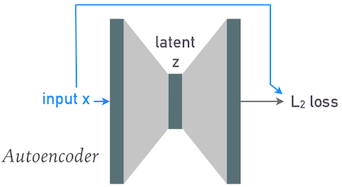

### **Sparse AE's**: 

The loss function is given by:

$$ L(\vec{x},f(g(\vec{x}))) + \Omega(\vec{h})$$

where 

$$\Omega(\vec{h})=\beta \sum_{j=1}^{D(\vec{h})} D_{KL}(\rho||\hat{\rho})$$

is a sparsity term that forces the average activation of element $j$ of $\vec{h}$

$$\hat{\rho}_j=\frac{1}{m}\sum_{i=1}^{m}[a_j^{(2)}x^{(i)}]$$

to be close to some small value $\rho$, typically around 0.05 if $D(\vec{h})$, the dimensionality of $\vec{h}$, is large.  

The sparsity term forces the average activation to be small, which effectively forces many of the nodes in the hidden layer (latent space) to be dormant when evaluating any given input.


### **Contractive AE's**: 

The loss function is given by:

$$ L(\vec{x},f(g(\vec{x}))) + \Omega(\vec{h},\vec{x})$$

where now 

$$\Omega(\vec{x},\vec{x}) = \lambda\sum_{i}||\nabla_{x}h_{i}||^2$$.  

This has the effect of penalizing networks in which the response in the latent space changes a lot when the input vector $\vec{x}$ is varied by a small amount.


### **Denoising AE's**: 

The loss is given by:

$$ L(\vec{x},f(g(\tilde{x})))$$

where $\tilde{x}$ is now a noisy version of $\vec{x}$.  So the network learns to remove the noise.

In all cases we were transforming either the inputs to the loss function, or adding a penalty term to the loss function, or both.

## Variational AutoEncoders

Variational AutoEncoders do something similar: they also introduce a penalty term in the loss function to force the network to learn in a certain way.  In this case, the penalty term affects the variables of the hidden/latent layer directly, rather than indirectly as in the above examples, to put the latent space into a certain form that will make it easy to sample from later.

To understand VAE's, let's consider the following situation.  

* We have trained an AutoEncoder to learn what a typical event record in a given sample looks like, by feeding it many examples from the sample and asking it to compress a given record into a lower-dimensional space, and uncompress it back to a representation of the original that's as close to the original as possible.  In the process of doing this training, each node in the hidden layer activates slightly differently for any given input, and summing over all events in the sample gives a distribution of activations for any given node in the latent space.  Maybe the first node has a distribution that looks like $x^{2}$, the second node has a distribution that looks like $\sin(x)$, and so on.  
* Now we want to use this AE to generate *new* outputs, not seen before in training, by generating a new set of outputs from the latent space.  When generating this new set of ouputs, we should try to make sure that we're sampling following the probability distributions for each given node, so from a PDF that looks like $x^2$ for node one, $\sin(x)$ for node 2, etc.  This means we need to know the PDF for each node *in advance* in order to use this as a generative model.

Knowing the PDF's in advance is not trivial!  First, because they're unlikely to be as simple as $x^{2}$ or $\sin(x)$, and second because we don't necessarily want to keep track of all that information with the network.

The solution, then is to *train the hidden layer to activate according to a pre-defined probability distribution*, so you know what the PDF is even before training happens.  In this case we use the normal distribution, because we like that one.  Then, in order to generate new events by sampling from the latent space, we just need to sample from gaussian distributions.  

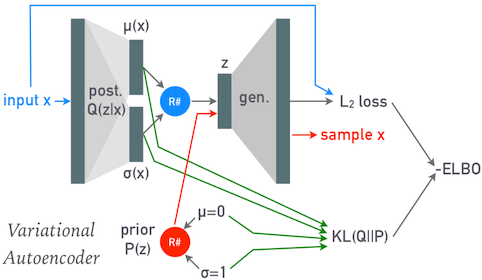


In the diagram above, the $\vec{x}$ is fed into linear/connected layers that go through two parallel hidden layers, into a final hidden layer that encodes $\vec{x}$ into a lower-dimensional $\vec{z}$.  We to be able to meaningfully sample the elements of $\vec{z}$ later on, so we play a trick by constraining the form of AE nodes just before the layer that contains $\vec{z}$.  

The layer just before $\vec{z}$ contains the two parallel hidden layers, each of the same dimension as $\vec{z}$: one set of nodes that, when evaluated over the entire sample, will have PDF's that corresponds to the means $\mu_{j}$ of the gaussian distribution in the corresponding node of $\vec{z}$, while the other set of nodes will encode the widths $\sigma_{j}$.  These are represented by vectors $\vec{\mu}$ and $\vec{\sigma}$ of an $n$-dimensional Gaussian distribution in the $n$-dimensional latent space.  For a 2D Gaussian, $\vec{\mu}=(\mu_1, \mu_2)$ and $\vec{\sigma}=(\sigma_1, \sigma_2)$, which gives the means and deviations along the two dimensions of the distribution.  We then parameterize $\vec{z}=\mu_{z}(\vec{x})+\vec{\epsilon}\cdot\sigma_{z}(\vec{x})$ where $\vec{\epsilon}$ is a noise term sampled from a multivariate Gaussian.

Note that any given input $\vec{x}^{(i)}$ will map onto specific values of $\vec{\mu}$ and $\vec{\sigma}$, and will correspond to a specific value of $\vec{z}$: this specific value of $\vec{z}$ will then be fed into the decoder to reconstruct the original input $\vec{x}$.  We use a loss function that includes a term that minimizes the distance between $\vec{x}$ and $\vec{x}'$.

The way we get the hidden layers to correspond to $\vec{\mu}$ and $\vec{\sigma}$ values is to add a penalty term that forces the hidden layers to take that form.  In this case we make use of the (negative) [Evidence Lower BOund (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound) function.

$$L(\vec{x},\vec{x}',\vec{z}) = L(\vec{x},\vec{x}') + \lambda D_{KL}[q(\vec{z}|\vec{x})||p(\vec{z})]$$

where $p(\vec{z})$ is taken to be a multivariate isotropic Gaussian = $\mathcal{N}(\vec{0},\vec{1})$, and $q(\vec{z}|\vec{x})=\mathcal{N}(\mu_z(\vec{x}),\sigma_z(\vec{x}))$, and $L(\vec{x},\vec{x}')$ is either the MSE loss $\frac{1}{N}\sum_x||\vec{x}-\vec{x}'||^2$, or BCE, or something else that we know how to calculate.  Since the $D_{KL}$ divergence goes as:

$$D_{KL}[q(\vec{z}|\vec{x})||p(\vec{z})] = q(\vec{z}|\vec{x})\log\frac{p(\vec{z})}{q(\vec{z}|\vec{x})}$$

we can reduce the total loss function (assuming MSE for $L(\vec{x},\vec{x}')$) to:

$$ L(\vec{x},\vec{x}',\vec{z}) = \frac{1}{N}\sum_x\left[ ||\vec{x}-\vec{x}'||^2 + \frac{1}{2}\left(1+\log\sigma_z^2(\vec{x})-\mu_{z}^2(\vec{x})-\sigma_{z}^2(\vec{x})\right) \right]$$

which is now something that can be solved analytically at each stage of the training.

When we train a network this way, we now know exactly what the distribution of $\vec{z}$ values will be: $p(\vec{z})$ is a multidimensional gaussian, so we can sample from that distribution to get "reasonable" elements of $\vec{z}$ to pass into the decoding network.  The random sampling that we do of the multivariate gaussian is unlikely to pick exactly the values that correspond to a specific training event -- instead it's more likely that the values it chooses will be completely new, and yet still *completely consistent* with values that could have come from a 'real' training event!

## Example VAE

Let's get to an example.

In [3]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define the datasets.  We'll use MNIST images for this example.

In [4]:
batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True, 'batch_size': batch_size, 'shuffle': True}

train_data   = MNIST('./data', train=True,  download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

test_data   = MNIST('./data', train=False, download=False,transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

We'll want to look at the images at some point: here's a short function to show a few images:

In [5]:
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i))

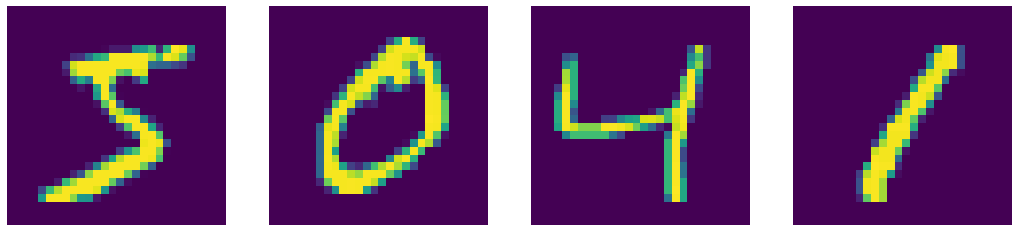

In [6]:
display_images(None,train_data,1)

In [7]:
print(train_data.data.shape)

torch.Size([60000, 28, 28])


Now define the model.  We'll take our raw images that have 28x28=784 pixels and encode them into a 20-dimensional latent space.

In [8]:
d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.LeakyReLU(0.2),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.LeakyReLU(0.2),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    # function to compute the latent space variable z
    def reparameterise(self, mu, logvar):
        if self.training:
            # std deviation
            std = logvar.mul(0.5).exp_()
            
            # noise
            eps = std.new_empty(std.size()).normal_()
            
            # z=mu + noise*std
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        # run the encoder.  this gives us two vectors of d entries per vector.
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        
        # compute the latent space variable z
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        
        # run the decoder and return the result
        return self.decoder(z), mu, logvar
    
model = VAE().to(device)

Set the optimizer:

In [9]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

Define our own loss function, here based on either a Binary Cross Entropy (BCE) or MSE loss: 

Loss = BCE + β * D_KL 

summed over all elements and batch entries.

In [10]:
def loss_function_BCE(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD

def loss_function_MSE(x_hat, x, mu, logvar, β=1):
    MSE = nn.functional.mse_loss(x_hat, x.view(-1,784), reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return MSE + β * KLD

loss_function=loss_function_BCE

Now we can train and test in the usual loop, with a twist: when testing, we want to keep track of more than just the losses, but also the values of the nodes in the hidden layers:

====> Test set loss: 544.4270
====> Epoch: 1 Average loss: 185.2989
====> Test set loss: 130.2376
====> Epoch: 2 Average loss: 129.5243
====> Test set loss: 113.0181
====> Epoch: 3 Average loss: 119.8227
====> Test set loss: 107.8557
====> Epoch: 4 Average loss: 116.0618
====> Test set loss: 104.5088
====> Epoch: 5 Average loss: 113.6644
====> Test set loss: 103.1165
====> Epoch: 6 Average loss: 112.0587
====> Test set loss: 101.7660
====> Epoch: 7 Average loss: 110.8137
====> Test set loss: 100.3925
====> Epoch: 8 Average loss: 109.8511
====> Test set loss: 100.5736
====> Epoch: 9 Average loss: 109.0081
====> Test set loss: 99.1344
====> Epoch: 10 Average loss: 108.4252
====> Test set loss: 99.1632


/Users/ngokhang2000/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/Users/ngokhang2000/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


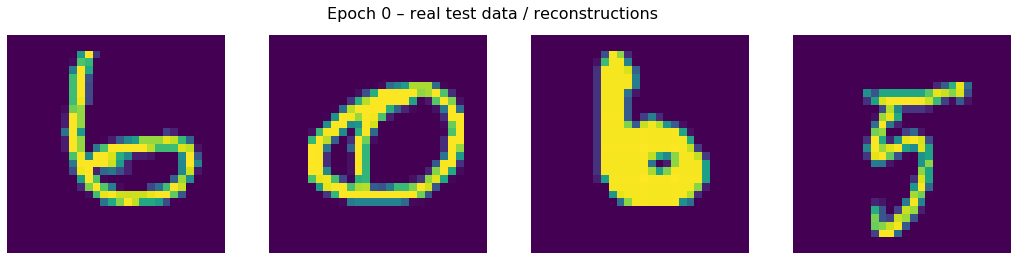

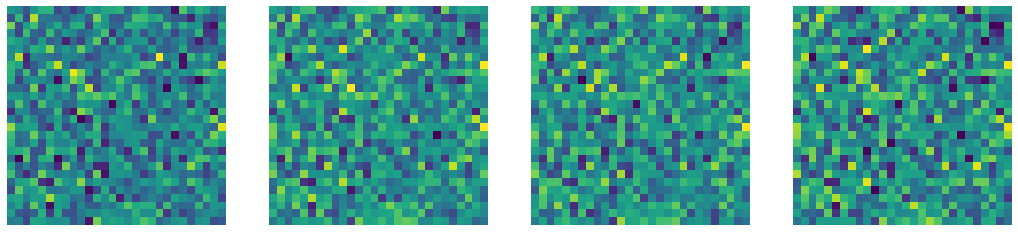

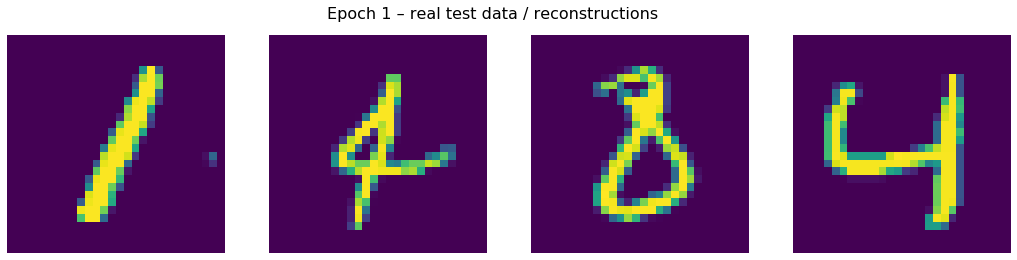

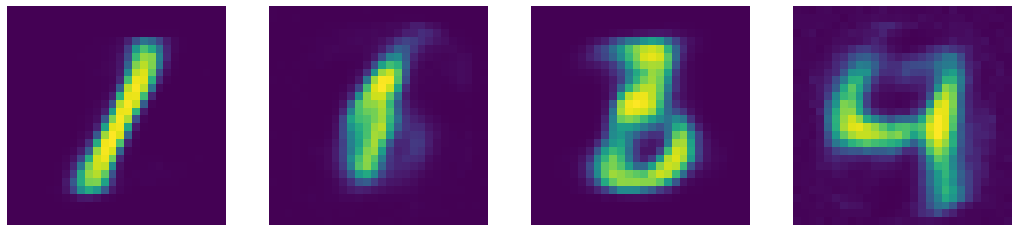

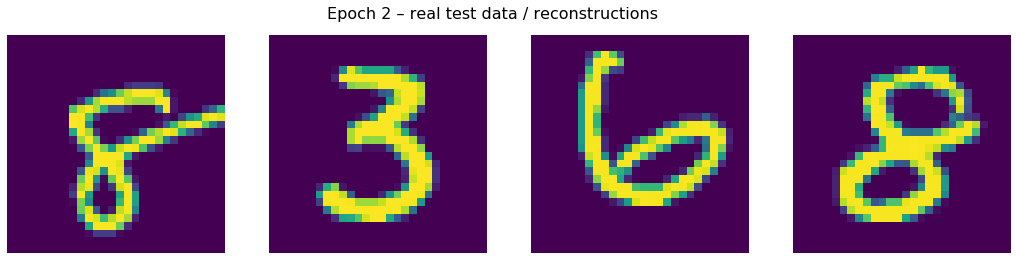

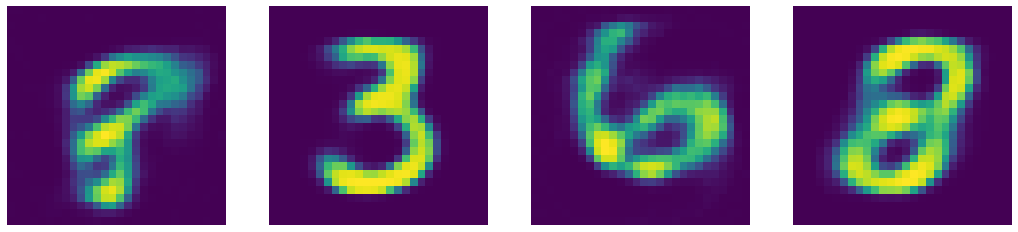

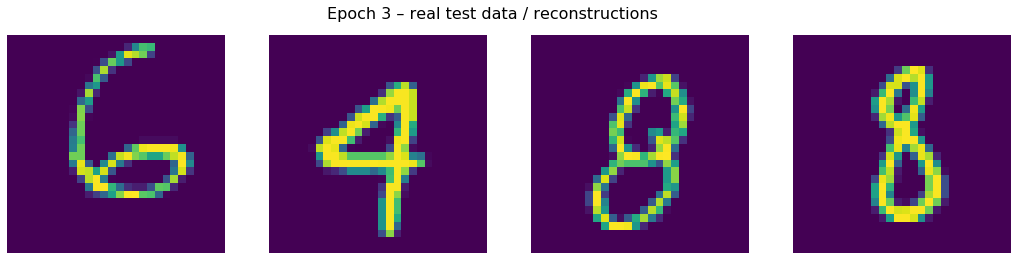

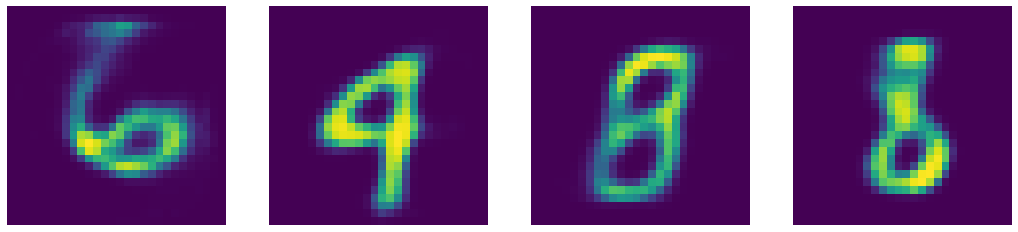

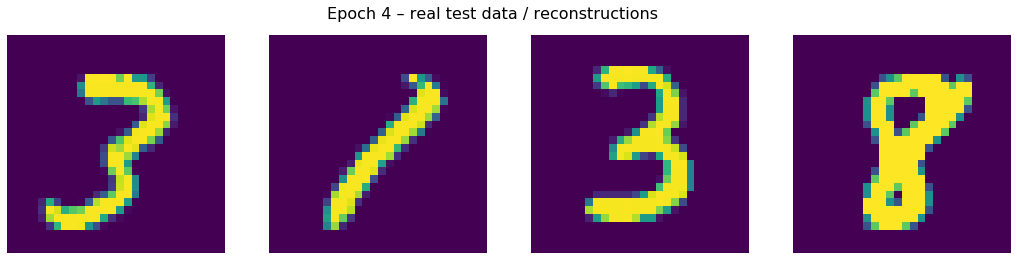

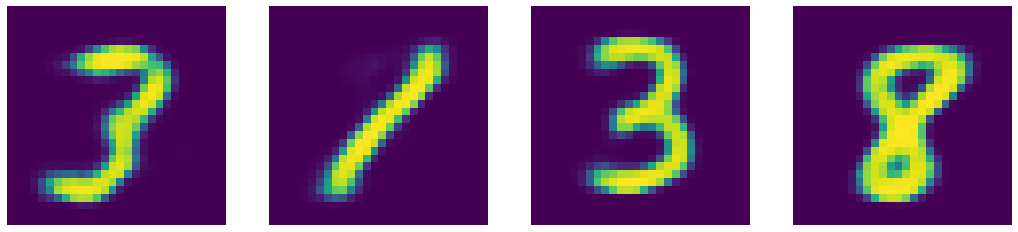

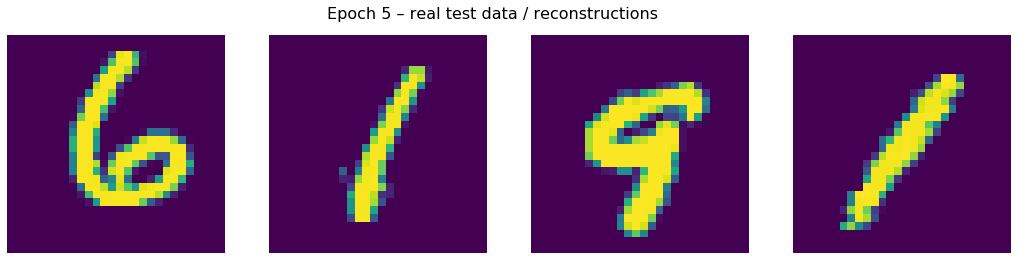

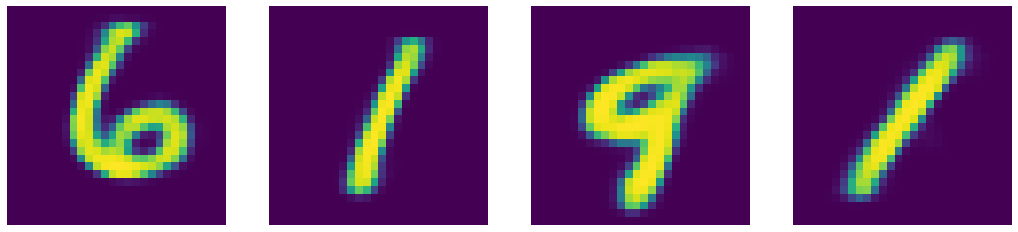

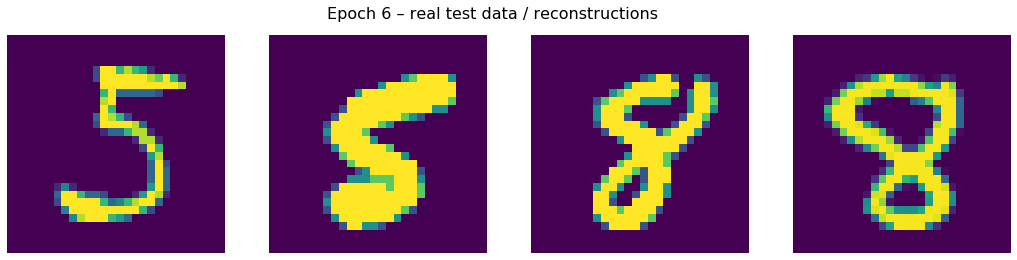

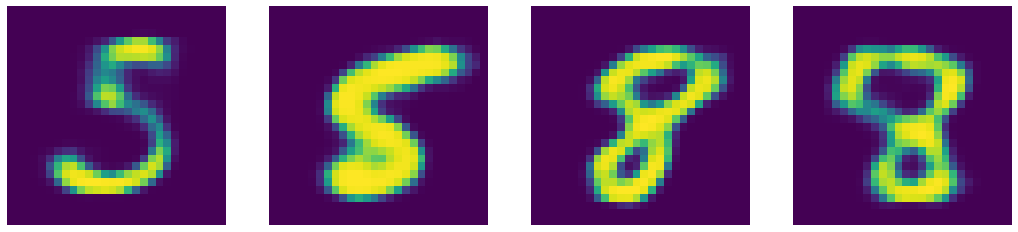

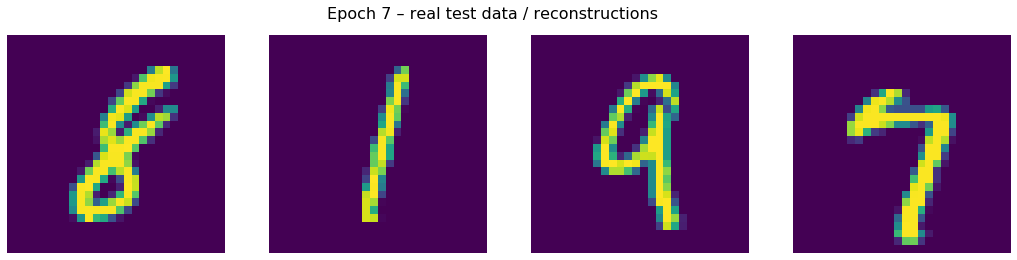

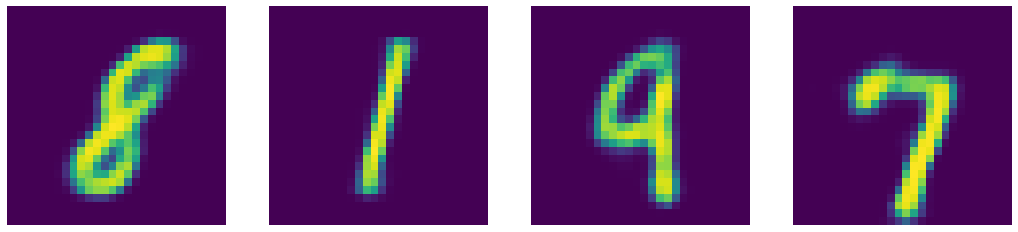

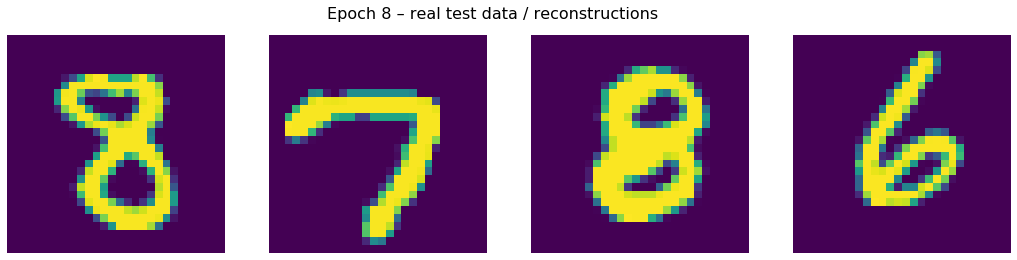

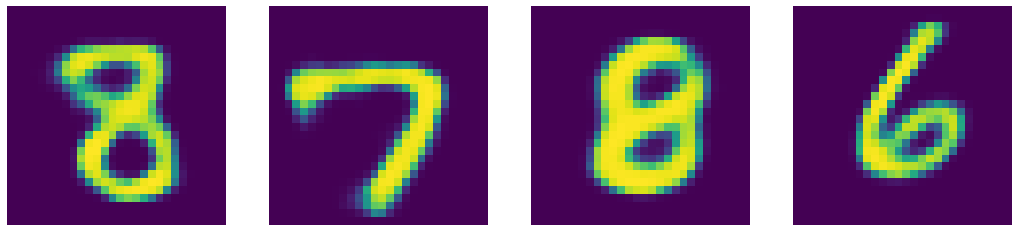

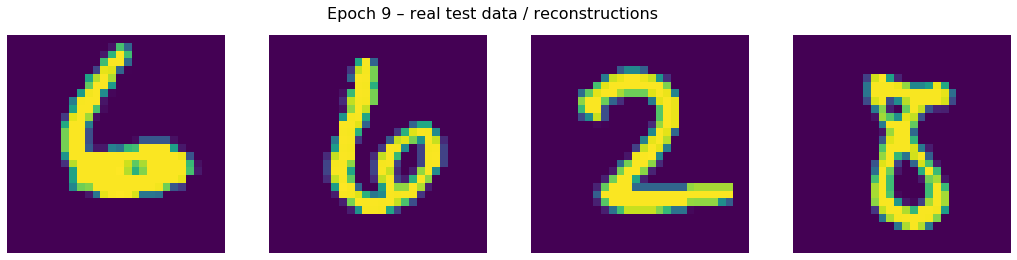

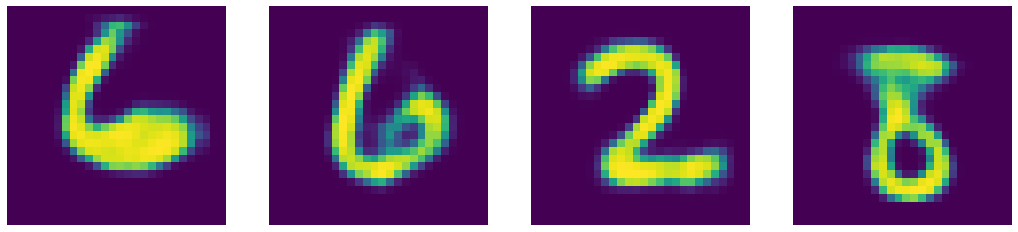

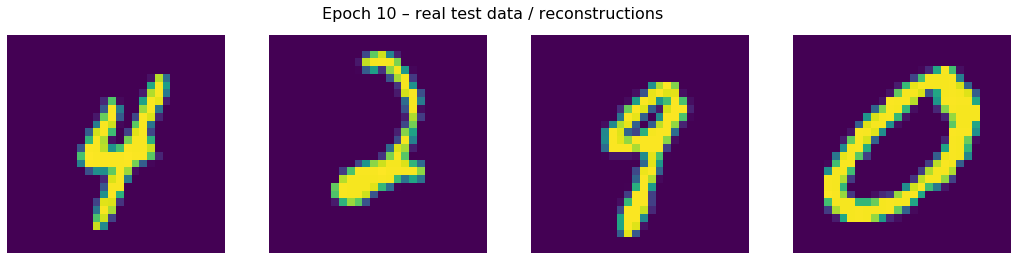

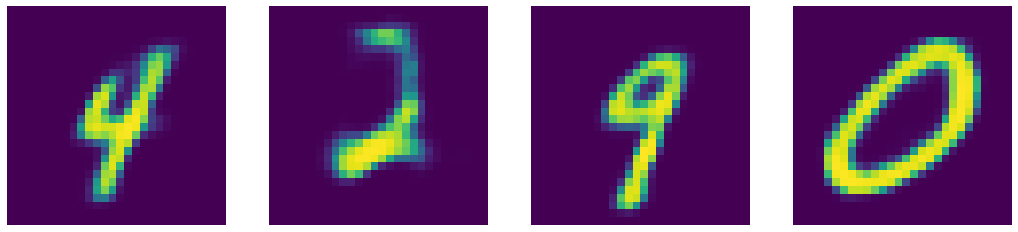

In [11]:
epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

We could keep going, but after 10 epochs this already looks pretty good.  Now let's have some fun!

First we can generate some "new" samples:

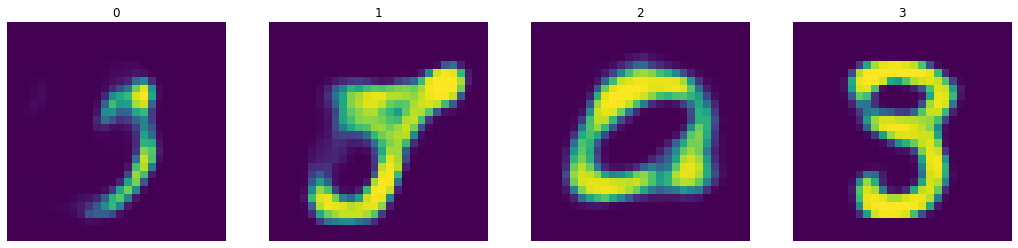

In [12]:
N = 4
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N//4, count=True)

Display all images from the last test batch:

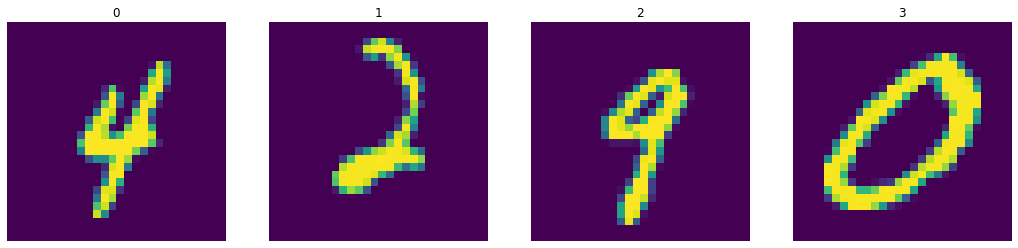

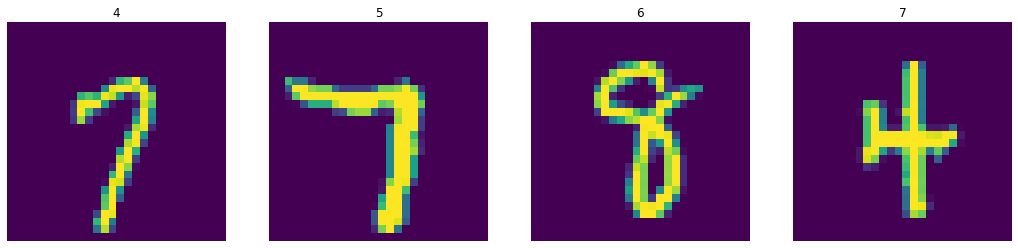

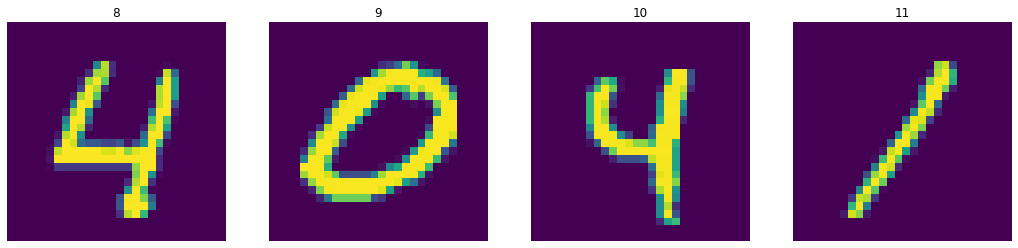

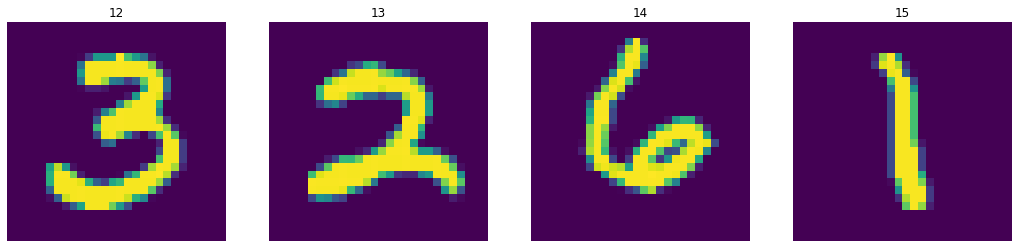

In [13]:
display_images(None, x, 4, count=True)

Now let's interpolate between two different images.  First let's choose two:

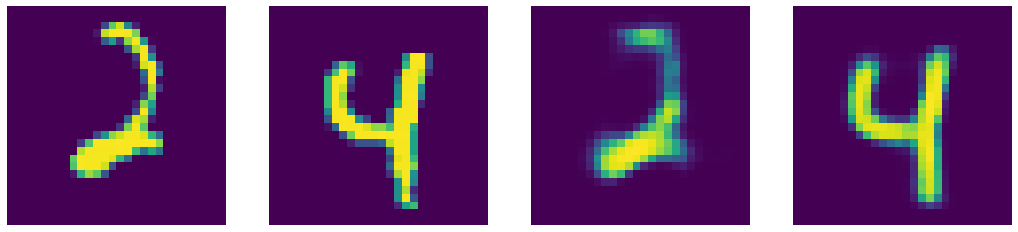

In [14]:
A, B = 1,10
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

Now interpolate between those two images, in $N=8$ different steps:

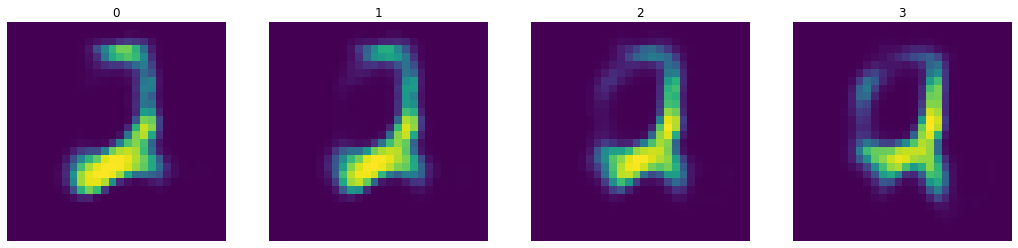

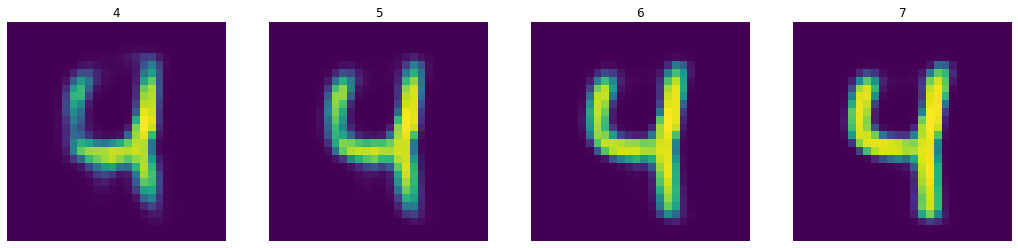

In [15]:
N = 8
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

**Exercises**: play around with the VAE above.  Some suggestions:
* Change from MSE loss to BCE loss.  Remember, when using BCE loss we'll need to apply a sigmoid activation function at the end of the decoder layers!
* Change the learning rate, batch size, number of epochs, number of latent-space dimensions, etc.

References:
* [Machine Learning and Statistics Course at UCI](https://slugpu.ucsc.edu:8443/user/mhance/notebooks/MachineLearningStatistics/notebooks/UnsupervisedDeep.ipynb)
* [Pytorch and Deep Learning course at NYU](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/11-VAE.ipynb)